# JWST Mirage: synthetic observation from `fits`

Standard libraries:

In [1]:
import os
import numpy
import astropy.units
import astropy.coordinates
import astropy.io.fits
import astropy.modeling
import matplotlib.pyplot

Environment variables, so that these do not need to be set in `~/.bashrc`/... (adjust the paths as you like):

In [2]:
HOME = os.path.expanduser("~")
os.environ["MIRAGE_DATA"] = f"{HOME:s}/Lib/Mirage/mirage_data"
os.environ["CRDS_DATA"] = f"{HOME:s}/Lib/Mirage/CRDS"
os.environ["CRDS_PATH"] = f"{HOME:s}/Lib/Mirage/CRDS_CACHE"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

Specific libraries (put after the variables in case they need those for initialization):

In [3]:
import yaml
import mirage.catalogs.catalog_generator
import mirage.dark.dark_prep
import mirage.ramp_generator.obs_generator
import mirage.imaging_simulator
import mirage.reference_files.downloader
import mirage.seed_image.fits_seed_image
import mirage.yaml.yaml_generator
import jwst.pipeline

#### Download reference files

This will re-download even if the files already exist in `${MIRAGE_DATA}`, so run this only once.

In [ ]:
def reffiles_download(path=f"{HOME:s}/Lib/Mirage-Data") :
    mirage.reference_files.downloader.download_reffiles(path, instrument="NIRCam", dark_type="linearized")
    return
reffiles_download()

## Generate `fits` from `RadMC-3D` output

`radmc3dPy.image.fitswrite()` includes a mandatory bandwidth, which we would like to circumvent; hence, here is a custom routine for `fits` creation.

This also sets the center pixel coordinates of the created `fits` files to a value that is centered on the subarray chosen here.

For this subarray, use one of (`B1_FULL`, `B1_SUB320`, `B1_SUB160`).
For the other options (`B1_SUB640`, `B1_SUB64P`), and other modules (`B2`, `B3`, `B4`), the center coordinate may either be missing from the lookup file (`custom-input/fits-centering.npz`), or may be off by a few arcsecs.

Setting a different position may be difficult because the default was hardcoded in at least one source file last time I checked.

In [4]:
folder_input = "input"
folder_output = "output"
filename_radmc = f"custom-input/stokes-i75.out"
subarray = "B1_SUB320".upper()



def radmc_to_fits(filename_radmc, subarray, dpc=100.0*astropy.units.pc) :
    with open(filename_radmc) as file :
        data = file.read().splitlines()
    data = [line.split() for line in data]
    header = data[:5]
    assert header[0]==['3'] and len(header[1])==2 and header[2]==['1'], \
        f"RadMC-3D file format not as expected: '{filename_radmc:s}'"
    npix = numpy.int_(header[1])
    pixsize = numpy.float_(header[3]) * astropy.units.cm
    lambda_obs = numpy.float_(header[4]) * astropy.units.micron
    data = numpy.float_(numpy.array([line for line in data[5:] if line!=[]])) \
        * astropy.units.erg/astropy.units.s/astropy.units.cm**2/astropy.units.Hz/astropy.units.sr
    data = data.to(astropy.units.MJy/astropy.units.sr)
    
    assert data.shape == (npix[0]*npix[1], data.shape[1]), \
        f"RadMC-3D file format not as expected: '{filename_radmc:s}'"
    hdu = astropy.io.fits.PrimaryHDU(data[:,0].reshape(npix).value)
    
    filename_folder = filename_radmc[:filename_radmc.rfind('/')+1] if '/' in filename_radmc else ""
    incl = int(filename_radmc[filename_radmc.rfind("stokes-i")+8:filename_radmc.rfind(".out")])
        # 'int' implicitly asserts that we have a number
    filename_fits = f"{folder_output:s}/mirage-int-i{incl:d}.fits"
    hdu.writeto(filename_fits, overwrite=True)
    
    #def to_deg(d, m, s) :
    #    return astropy.coordinates.Angle((d,m,s), unit=astropy.units.deg).to_value(astropy.units.deg)
    
    with astropy.io.fits.open(filename_fits, mode="update") as hdul :
        header = hdul["PRIMARY"].header
        # Pixel sizes:
        header["CDELT1"] = -(pixsize[0]/dpc).to_value(astropy.units.deg, astropy.units.dimensionless_angles())
        header["CUNIT1"] = "DEG"
        header["CTYPE1"] = "RA---SIN"
        header["CRPIX1"] = 0.5 * (npix[0]+1.0)
        header["CDELT2"] = (pixsize[1]/dpc).to_value(astropy.units.deg, astropy.units.dimensionless_angles())
        header["CUNIT2"] = "DEG"
        header["CTYPE2"] = "DEC--SIN"
        header["CRPIX2"] = 0.5 * (npix[1]+1.0)
        # Coordinates:
        crvals = numpy.load("custom-input/fits-centering.npz")
        header["CRVAL1"] = crvals[subarray][0]
        header["CRVAL2"] = crvals[subarray][1]
        header["CROTA2"] = 0.0  # This value is arbitrary.
        header["CD1_1"] = header["CDELT1"] * numpy.cos(header["CROTA2"])
        header["CD1_2"] = -header["CDELT2"] * numpy.sin(header["CROTA2"])
        header["CD2_1"] = header["CDELT1"] * numpy.sin(header["CROTA2"])
        header["CD2_2"] = header["CDELT2"] * numpy.cos(header["CROTA2"])
        # Value units:
        header["BUNIT"] = "MJy/sr"
        header["BTYPE"] = "INTENSITY"
        header["BZERO"] = 0.0
        header["BSCALE"] = 1.0
        # "What Mirage also needs":
        header["TELESCOP"] = "NONE"
        header["INSTRUME"] = "NONE"
        hdul.flush()
    
    print(f"Created new fits file for '{subarray:s}': '{filename_fits:s}'")
    return filename_fits

filename_fits = radmc_to_fits(filename_radmc, subarray)

Created new fits file for 'B1_SUB320': 'custom-output/mirage-int-i75.fits'


## Generate `yaml` files from `APT`

`Mirage`'s `yaml` generator expects `xml` and `pointing` files from `APT` (https://jwst-docs.stsci.edu/jwst-astronomers-proposal-tool-overview).
Since it is slightly impractical to re-run `APT` after every change to the input parameters, some of the changes can be dealt with here.

For the `readout` pattern, `RAPID` and `DEEP8` have been implemented.
These are needed only for determining the `scienceduration` entry of the `xml` file; so if that entry does not matter (which preliminary testing suggests), any readout pattern should be possible.
The permitted numbers of groups and integrations have been adopted from `APT`.

The `xml` file generated uses only a short filter, and no long filter (this could be modified of course).
For the available filters, see https://jwst-docs.stsci.edu/near-infrared-camera/nircam-instrumentation/nircam-filters.

The `yaml` generator resides in the same notebook cell to avoid accidental modifications to just the `xml`or `yaml`files.
For possible input parameters, see also https://mirage-data-simulator.readthedocs.io/en/latest/example_yaml.html; from there:
* `cosmic_rays` can be one of (`SUNMIN`, `SUNMAX`, `FLARE`).
* `background` can be one of (`low`, `medium`, `high`), or possibly specify a value in $\mathrm{ADU/pixel/second}$.
* `dates` does not matter.
* `datatype` specifies the output to produce: (`raw`, `linear`, or `linear,raw`)

In [5]:
def apt_xml_make(subarrayname, readoutname, Ngroups, Nintegrations, filtername, folder_output=folder_output) :
    assert subarrayname[0] in ('A', 'B') and int(subarrayname[1]) in range(5) and subarrayname[2]=='_', \
        f"Subarray '{subarrayname:s}' unknown."
    assert subarrayname[3:] in ("SUB160", "SUB320", "SUB640", "FULL"), f"Subarray '{subarrayname:s}' unknown."
    
    assert 1<=Ngroups<=10, f"#groups must be within [1; 10], but is {Ngroups:d}."
    assert 1<=Ngroups<=200, f"#integrations must be within [1; 200], but is {Nintegrations:d}."
    ##("RAPID","BRIGHT1","BRIGHT2","SHALLOW2","SHALLOW4","MEDIUM2","MEDIUM8","DEEP2","DEEP8")
    assert readoutname in ("RAPID", "DEEP8"), f"Readout pattern '{readoutname:s}' unknown."
    
    if filtername in ("F162M", "F164N") :
        filtername += "+F150W2"
    filternames = ("F070W", "F090W", "F115W", "F150W", "F150W2", "F140M", "F162M+F150W2", "F164N+F150W2", \
        "F182M", "187N", "F200W", "F210M", "F212N")
    assert filtername in filternames, f"Filter '{filtername:s}' unknown."
    
    with open(f"{folder_input:s}/template-img-B.xml", 'r') as file :
        data = file.read()
    data = data.replace("S*U*B*A*R*R*A*Y", subarrayname[3:])
    data = data.replace("S*H*O*R*T*F*I*L*T*E*R", filtername)
    data = data.replace("R*E*A*D*O*U*T*P*A*T*T*E*R*N", readoutname)
    data = data.replace("N*G*R*O*U*P*S", str(Ngroups))
    data = data.replace("N*I*N*T*E*G*R*A*T*I*O*N*S", str(Nintegrations))
    data = data.replace("S*C*I*E*N*C*E*D*U*R*A*T*I*O*N", "0")
    
    filename_xml = f"{folder_output:s}/apt.xml"
    with open(filename_xml, 'w') as file :
        file.write(data)
    return filename_xml

filename_xml = apt_xml_make(subarray, "DEEP8", Ngroups=10, Nintegrations=10, filtername="F070W")
filename_pointing = f"{folder_input:s}/eo-test.pointing"



yamlgen = mirage.yaml.yaml_generator.SimInput(filename_xml, filename_pointing, verbose=True,
    output_dir=f"{folder_output:s}",
    cosmic_rays={"library":"SUNMAX", "scale":1.0},
    #catalogs=catalogs,
    background="low",
    roll_angle=0.0,
    dates="2021-12-02",
    simdata_output_dir=f"{folder_output:s}",
    datatype="linear,raw")
    # 'dates' does not matter!
yamlgen.use_linearized_darks = True  # should already be implicit, but better safe than sorry
yamlgen.create_inputs()
#print(yamlgen.info())

2021-10-11 18:14:03,162 - mirage.yaml.yaml_generator - INFO - Running yaml_generator....
2021-10-11 18:14:03,163 - mirage.yaml.yaml_generator - INFO - 
2021-10-11 18:14:03,165 - mirage.yaml.yaml_generator - INFO - using APT xml file: custom-output/apt.xml
2021-10-11 18:14:03,165 - mirage.yaml.yaml_generator - INFO - 
2021-10-11 18:14:03,166 - mirage.yaml.yaml_generator - INFO - Original log file name: ./mirage_latest.log
2021-10-11 18:14:03,197 - mirage.apt.read_apt_xml - INFO - Running read_apt_xml....
2021-10-11 18:14:03,198 - mirage.apt.read_apt_xml - INFO - 
2021-10-11 18:14:03,201 - mirage.apt.read_apt_xml - INFO - target_info:
2021-10-11 18:14:03,203 - mirage.apt.read_apt_xml - INFO - {'MAIN': ('03:32:40.0000', '-27:49:0.00')}
2021-10-11 18:14:03,207 - mirage.apt.read_apt_xml - INFO - ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
2021-10-11 18:14:03,212 - mirage.apt.read_apt_xml - INFO - Observation `001` labelled `None` uses

The `yaml` generator creates one file per module (`B1` through `B5`$\equiv$`B_FULL`).
Choose the one for `B1`.

In [6]:
def yaml_list(yamlgen) :
    print("YAML files:")
    for file in yamlgen.yaml_files :
        print(f"* '{file:s}'")
    print()
    return
yaml_list(yamlgen)

def yaml_choice(yamlgen, subarray) :
    found = False
    for yamlfile in yamlgen.yaml_files :
        module = yamlfile[yamlfile.find("_00001_nrc")+10:yamlfile.find(".yaml")].upper()
        if module == subarray[:2] :
            found = True
            break
    assert found, f"Could not find YAML file corresponding to subarray '{subarray:s}'."
    print(f"Selected YAML file:\n* '{yamlfile:s}'")
    return yamlfile

yamlfile = yaml_choice(yamlgen, subarray)

YAML files:
* '/e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb1.yaml'
* '/e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb2.yaml'
* '/e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb3.yaml'
* '/e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb4.yaml'
* '/e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb5.yaml'

Selected YAML file:
* '/e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb1.yaml'


## Create synthetic observations

(skipping extended source catalog)

#### Extract Gaussian FWHM from `fits` file

`Mirage` expects the FWHM of the input data to be better than what JWST can deliver, in order to avoid over-sharpening the output.

Filename: custom-output/mirage-int-i75.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (800, 800)   float64   
None


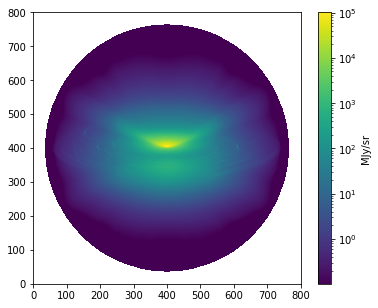

Fitting results:
* mean: x, y:   3.35751e-16   3.35751e-16
* FWHM: x, y:   2.35482e+00   2.35482e+00
* std:  x, y:   1.00000e+00   1.00000e+00
FWHM: 2.07224e-02 arcsec


In [7]:
def fits_fwhm_compute(filename) :
    with astropy.io.fits.open(filename) as hdul :
        print(hdul.info())
        header = hdul[0].header
        data = hdul[0].data
    
    if header["BUNIT"].upper() == "JY/PIXEL" :
        norm = matplotlib.colors.LogNorm(vmin=1.0e-8, vmax=data.max())
    elif header["BUNIT"].upper() == "MJY/SR" :
        norm = matplotlib.colors.LogNorm(vmin=1.0e-6*data.max(), vmax=data.max())        
    # Visual check of the data:
    fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(6,5), facecolor="white")
    mesh = ax.pcolormesh(data, norm=norm)
    fig.colorbar(mesh, ax=ax, label=header["BUNIT"])
    matplotlib.pyplot.show()
    
    # Grid for fitting:
    gd_y, gd_x = numpy.mgrid[0:data.shape[0], 0:data.shape[1]]
    # Fitting:
    psf_fit = astropy.modeling.fitting.LevMarLSQFitter()(astropy.modeling.models.Gaussian2D(), \
        gd_x, gd_y, data)
    print("Fitting results:")
    print(f"* mean: x, y:   {psf_fit.x_mean.value:1.5e}   {psf_fit.y_mean.value:1.5e}")
    print(f"* FWHM: x, y:   {psf_fit.x_fwhm:1.5e}   {psf_fit.y_fwhm:1.5e}")
    print(f"* std:  x, y:   {psf_fit.y_stddev.value:1.5e}   {psf_fit.y_stddev.value:1.5e}")
    
    fwhm_x = psf_fit.x_fwhm * astropy.units.Unit(header["CUNIT1"].lower())
    fwhm_y = psf_fit.y_fwhm * astropy.units.Unit(header["CUNIT2"].lower())
    assert numpy.isclose(fwhm_x, fwhm_y, rtol=0.01), "FWHM in x and y significantly differ."
    val = (fwhm_y * header["CD2_2"]).to(astropy.units.arcsec)
    print(f"FWHM: {val:1.5e}")
    return val

fits_fwhm = fits_fwhm_compute(filename_fits)

In case this value is to high, we can simply replace it by an arbitrary value (the effect on the data product should be less significant than "no product at all").

#### Resample `fits` to JWST PSF

In [8]:
def fits_resample(yamlfile, filename_fits, fits_fwhm) :
    with open(yamlfile, 'r') as file :
        yamlparam = yaml.safe_load(file)
    
    folder_sim = yamlparam["Output"]["directory"]
    filename_sim = yamlparam["Output"]["file"]
    filename_crop_full = os.path.join(folder_sim, filename_sim.replace(".fits", "_cropped.fits"))
    filename_blot = filename_sim.replace(".fits", "_resampled.fits")
    filename_blot_full = os.path.join(folder_sim, filename_blot)
    filename_cat = filename_sim.replace(".fits", "_source.cat")
    
    seed = mirage.seed_image.fits_seed_image.ImgSeed(paramfile=yamlfile,
        mosaic_file=filename_fits,
        cropped_file=filename_crop_full,
        outdir=yamlparam["Output"]["directory"],
        blotted_file=filename_blot,
        mosaic_fwhm=fits_fwhm.value,
        mosaic_fwhm_units=str(fits_fwhm.unit),
        gaussian_psf=True)
    seed.crop_and_blot()
    return filename_crop_full, filename_blot_full, seed

filename_crop, filename_blot, imgseed = fits_resample(yamlfile, filename_fits, fits_fwhm)

2021-10-11 18:14:09,878 - mirage.seed_image.fits_seed_image - INFO - 
2021-10-11 18:14:09,879 - mirage.seed_image.fits_seed_image - INFO - 
2021-10-11 18:14:09,880 - mirage.seed_image.fits_seed_image - INFO - Running fits_seed_image....
2021-10-11 18:14:09,881 - mirage.seed_image.fits_seed_image - INFO - 
2021-10-11 18:14:09,882 - mirage.seed_image.fits_seed_image - INFO - using parameter file: /e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb1.yaml
2021-10-11 18:14:09,883 - mirage.seed_image.fits_seed_image - INFO - 
2021-10-11 18:14:09,884 - mirage.seed_image.fits_seed_image - INFO - Original log file name: ./mirage_latest.log
2021-10-11 18:14:13,216 - mirage.psf.psf_selection.get_psf_wings - INFO - PSF wings will be from: nircam_nrcb1_f070w_clear_fovp401_samp1_predicted_realization0.fits
2021-10-11 18:14:13,810 - mirage.seed_image.fits_seed_image - INFO - JWST FWHM in pix: 1.3593623973240383
2021-10-11 18:14:13,814 - mirage.seed_image.fits_seed_ima

2021-10-11 18:14:15,502 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-10-11 18:14:15,502 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-10-11 18:14:15,680 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from temp_wcs_container.fits>,).


2021-10-11 18:14:15,680 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from temp_wcs_container.fits>,).


2021-10-11 18:14:15,684 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-11 18:14:15,684 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-11 18:14:16,493 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2021-10-11 18:14:16,493 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done
2021-10-11 18:14:22,366 - mirage.seed_image.save_seed.save - INFO - Seed image is 2D.
2021-10-11 18:14:22,435 - mirage.seed_image.fits_seed_image - INFO - Blotted image saved to: /e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb1_uncal_resampled.fits
2021-10-11 18:14:22,439 - mirage.seed_image.fits_seed_image - INFO - 
2021-10-11 18:14:22,443 - mirage.seed_image.fits_seed_image - INFO - fits_seed_image complete


#### Dark file

In [9]:
def dark_generate(yamlfile) :
    dark = mirage.dark.dark_prep.DarkPrep()
    dark.paramfile = yamlfile
    dark.prepare()
    return dark

dark = dark_generate(yamlfile)

2021-10-11 18:14:22,507 - mirage.dark.dark_prep - INFO - 
2021-10-11 18:14:22,511 - mirage.dark.dark_prep - INFO - 
2021-10-11 18:14:22,514 - mirage.dark.dark_prep - INFO - Running dark_prep..
2021-10-11 18:14:22,514 - mirage.dark.dark_prep - INFO - 
2021-10-11 18:14:22,515 - mirage.dark.dark_prep - INFO - Reading parameter file: /e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb1.yaml
2021-10-11 18:14:22,518 - mirage.dark.dark_prep - INFO - 
2021-10-11 18:14:22,520 - mirage.dark.dark_prep - INFO - Original log file name: ./mirage_latest.log
2021-10-11 18:14:22,524 - mirage.utils.utils.full_paths - INFO - From CRDS, found /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_mask_0042.fits as the badpixmask reference file.
2021-10-11 18:14:22,526 - mirage.utils.utils.full_paths - INFO - From CRDS, found /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_superbias_0020.fits as the superbias referenc

2021-10-11 18:14:36,256 - mirage.dark.dark_prep - INFO - Averaging dark current ramp. Frames [140 141 142 143 144 145 146 147], to become group 7
2021-10-11 18:14:36,468 - mirage.dark.dark_prep - INFO - Averaging dark current ramp. Frames [160 161 162 163 164 165 166 167], to become group 8
2021-10-11 18:14:36,679 - mirage.dark.dark_prep - INFO - Averaging dark current ramp. Frames [180 181 182 183 184 185 186 187], to become group 9
2021-10-11 18:14:36,905 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 10, 2048, 2048) to match the input readpattern of DEEP8
2021-10-11 18:14:36,919 - mirage.dark.dark_prep - INFO - File number 0 will be used for integrations [0 1]
2021-10-11 18:14:36,931 - mirage.dark.dark_prep - INFO - Working on dark file: /e/ocean1/users/rfranz/Lib/Mirage/mirage_data/nircam/darks/linearized/B1/Linearized_Dark_and_SBRefpix_NRCNRCB1-DARK-60090405201_1_486_SE_2016-01-09T05h33m56_uncal.fits
2021-10-11 18:14:36,933 - mirage.dark.dark_prep - INFO - Reading

2021-10-11 18:15:16,498 - mirage.dark.dark_prep - INFO - Averaging dark current ramp. Frames [0 1 2 3 4 5 6 7], to become group 0
2021-10-11 18:15:16,718 - mirage.dark.dark_prep - INFO - Averaging dark current ramp. Frames [20 21 22 23 24 25 26 27], to become group 1
2021-10-11 18:15:16,932 - mirage.dark.dark_prep - INFO - Averaging dark current ramp. Frames [40 41 42 43 44 45 46 47], to become group 2
2021-10-11 18:15:17,146 - mirage.dark.dark_prep - INFO - Averaging dark current ramp. Frames [60 61 62 63 64 65 66 67], to become group 3
2021-10-11 18:15:17,356 - mirage.dark.dark_prep - INFO - Averaging dark current ramp. Frames [80 81 82 83 84 85 86 87], to become group 4
2021-10-11 18:15:17,568 - mirage.dark.dark_prep - INFO - Averaging dark current ramp. Frames [100 101 102 103 104 105 106 107], to become group 5
2021-10-11 18:15:17,780 - mirage.dark.dark_prep - INFO - Averaging dark current ramp. Frames [120 121 122 123 124 125 126 127], to become group 6
2021-10-11 18:15:17,991 - 

#### Observation generation

The `ImgSeed` object needs to be cropped to a possible non-`FULL` subarray manually because the `Observation` object does not seem capable of dealing with a full `ImgSeed` input yet.
However, I have not looked through the full source code, so perhaps there is a built-in solution.

In [10]:
def imgseed_crop(seed, subarray) :
    crop = {"info": seed.seedinfo}
    if "_FULL" in subarray :
        crop["image"] = seed.seed_image
        crop["segmap"] = seed.seed_segmap
    else :
        info = seed.seedinfo  # == crop["info"]; just for clarity
        image = seed.seed_image
        segmap = seed.seed_segmap
        Npix = [info["NOMXEND"]-info["NOMXSTRT"]+1, info["NOMYEND"]-info["NOMYSTRT"]+1]
        print(Npix)
            # This indirectly asserts that Npix is the same along x and y.
        def data_inds_get(data) :
            data_inds = data.nonzero()
            return [data_inds[0].min(), data_inds[0].max(), data_inds[1].min(), data_inds[1].max()]
        data_inds = numpy.array([data_inds_get(image), data_inds_get(segmap)], dtype=int).T
        ix1 = min(data_inds[0])
        ix2 = max(data_inds[1])
        iy1 = min(data_inds[2])
        iy2 = max(data_inds[3])
        print(ix1, ix2, iy1, iy2)
        def inds_adjust(Npix, i1, i2) :
            delta_half = (i2 - i1 - Npix) / 2.0
            i1 += int(numpy.ceil(delta_half))
            i2 -= int(numpy.floor(delta_half))
            if i1 < 0 :
                i2 -= i1
                i1 = 0
            return i1, i2
        ix1, ix2 = inds_adjust(Npix[0], ix1, ix2)
        iy1, iy2 = inds_adjust(Npix[1], iy1, iy2)
        
        crop["image"] = image[ix1:ix2, iy1:iy2]
        crop["segmap"] = segmap[ix1:ix2, iy1:iy2]
        print(f"Seed cropped to [{ix1:d}:{ix2:d}]x[{iy1:d}:{iy2:d}] ({ix2-ix1:d}x{iy2-iy1:d}).")
    return crop

imgseed_crop = imgseed_crop(imgseed, subarray)



def obs_generate(yamlfile, seed, dark) :
    obs = mirage.ramp_generator.obs_generator.Observation()
    obs.paramfile = yamlfile
    obs.seed = seed["image"]
    obs.segmap = seed["segmap"]
    obs.seedheader = seed["info"]
    obs.linDark = dark.prepDark
    obs.create()
    return obs

synobs = obs_generate(yamlfile, imgseed_crop, dark)
filename_uncal = filename_blot.replace("_resampled.fits", ".fits")
filename_lin = filename_blot.replace("_uncal_resampled.fits", "_linear.fits")

[320, 320]
95 322 81 309
Seed cropped to [49:369]x[35:355] (320x320).
2021-10-11 18:15:32,935 - mirage.ramp_generator.obs_generator - INFO - 
2021-10-11 18:15:32,936 - mirage.ramp_generator.obs_generator - INFO - 
2021-10-11 18:15:32,938 - mirage.ramp_generator.obs_generator - INFO - Running observation generator....
2021-10-11 18:15:32,939 - mirage.ramp_generator.obs_generator - INFO - 
2021-10-11 18:15:32,940 - mirage.ramp_generator.obs_generator - INFO - Reading parameter file: /e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb1.yaml
2021-10-11 18:15:32,941 - mirage.ramp_generator.obs_generator - INFO - 
2021-10-11 18:15:32,941 - mirage.ramp_generator.obs_generator - INFO - Original log file name: ./mirage_latest.log
2021-10-11 18:15:32,945 - mirage.utils.utils.full_paths - INFO - From CRDS, found /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_mask_0042.fits as the badpixmask reference file.
2021-10-11 18:15:32,947 -

2021-10-11 18:15:34,179 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 34
2021-10-11 18:15:34,192 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 35
2021-10-11 18:15:34,205 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 36
2021-10-11 18:15:34,218 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 37
2021-10-11 18:15:34,231 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 38
2021-10-11 18:15:34,245 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 39
2021-10-11 18:15:34,258 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 40 into group 2
2021-10-11 18:15:34,273 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 41 into group 2
2021-10-11 18:15:34,287 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 42 into group 2
2021-10-11 18:15:34,300 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 43 into group 2
2021-10-11 18:

2021-10-11 18:15:35,353 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 118
2021-10-11 18:15:35,367 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 119
2021-10-11 18:15:35,381 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 120 into group 6
2021-10-11 18:15:35,395 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 121 into group 6
2021-10-11 18:15:35,410 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 122 into group 6
2021-10-11 18:15:35,424 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 123 into group 6
2021-10-11 18:15:35,439 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 124 into group 6
2021-10-11 18:15:35,457 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 125 into group 6
2021-10-11 18:15:35,470 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 126 into group 6
2021-10-11 18:15:35,485 - mirage.ramp_generator.obs_gene

2021-10-11 18:15:36,521 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 11
2021-10-11 18:15:36,537 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 12
2021-10-11 18:15:36,552 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 13
2021-10-11 18:15:36,564 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 14
2021-10-11 18:15:36,577 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 15
2021-10-11 18:15:36,590 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 16
2021-10-11 18:15:36,603 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 17
2021-10-11 18:15:36,615 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 18
2021-10-11 18:15:36,627 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 19
2021-10-11 18:15:36,640 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 20 into group 1
2021-10-11 18:15:36,653 - mirage.ramp_generator.obs_gene

2021-10-11 18:15:37,615 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 95
2021-10-11 18:15:37,628 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 96
2021-10-11 18:15:37,641 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 97
2021-10-11 18:15:37,653 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 98
2021-10-11 18:15:37,666 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 99
2021-10-11 18:15:37,679 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 100 into group 5
2021-10-11 18:15:37,692 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 101 into group 5
2021-10-11 18:15:37,704 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 102 into group 5
2021-10-11 18:15:37,717 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 103 into group 5
2021-10-11 18:15:37,731 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 104 into gro

2021-10-11 18:15:38,692 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 178
2021-10-11 18:15:38,704 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 179
2021-10-11 18:15:38,717 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 180 into group 9
2021-10-11 18:15:38,730 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 181 into group 9
2021-10-11 18:15:38,743 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 182 into group 9
2021-10-11 18:15:38,757 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 183 into group 9
2021-10-11 18:15:38,770 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 184 into group 9
2021-10-11 18:15:38,784 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 185 into group 9
2021-10-11 18:15:38,797 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 186 into group 9
2021-10-11 18:15:38,811 - mirage.ramp_generator.obs_gene

2021-10-11 18:15:39,777 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 72
2021-10-11 18:15:39,791 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 73
2021-10-11 18:15:39,803 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 74
2021-10-11 18:15:39,816 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 75
2021-10-11 18:15:39,829 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 76
2021-10-11 18:15:39,843 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 77
2021-10-11 18:15:39,858 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 78
2021-10-11 18:15:39,870 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 79
2021-10-11 18:15:39,884 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 80 into group 4
2021-10-11 18:15:39,897 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 81 into group 4
2021-10-11 18:15:39,910 - mirage.ramp_gene

2021-10-11 18:15:40,866 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 155
2021-10-11 18:15:40,880 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 156
2021-10-11 18:15:40,893 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 157
2021-10-11 18:15:40,906 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 158
2021-10-11 18:15:40,919 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 159
2021-10-11 18:15:40,933 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 160 into group 8
2021-10-11 18:15:40,946 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 161 into group 8
2021-10-11 18:15:40,959 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 162 into group 8
2021-10-11 18:15:40,972 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 163 into group 8
2021-10-11 18:15:40,985 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 164 int

2021-10-11 18:15:41,970 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 48
2021-10-11 18:15:41,983 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 49
2021-10-11 18:15:41,996 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 50
2021-10-11 18:15:42,009 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 51
2021-10-11 18:15:42,021 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 52
2021-10-11 18:15:42,036 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 53
2021-10-11 18:15:42,049 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 54
2021-10-11 18:15:42,062 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 55
2021-10-11 18:15:42,076 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 56
2021-10-11 18:15:42,089 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 57
2021-10-11 18:15:42,102 - mirage.ramp_generator.obs_generator - INFO -

2021-10-11 18:15:43,064 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 131
2021-10-11 18:15:43,077 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 132
2021-10-11 18:15:43,090 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 133
2021-10-11 18:15:43,102 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 134
2021-10-11 18:15:43,115 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 135
2021-10-11 18:15:43,127 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 136
2021-10-11 18:15:43,140 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 137
2021-10-11 18:15:43,153 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 138
2021-10-11 18:15:43,166 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 139
2021-10-11 18:15:43,179 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 140 into group 7
2021-10-11 18:15:43,191 - mirage.ramp_generato

2021-10-11 18:15:44,141 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 25 into group 1
2021-10-11 18:15:44,154 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 26 into group 1
2021-10-11 18:15:44,168 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 27 into group 1
2021-10-11 18:15:44,181 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 28
2021-10-11 18:15:44,194 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 29
2021-10-11 18:15:44,207 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 30
2021-10-11 18:15:44,220 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 31
2021-10-11 18:15:44,233 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 32
2021-10-11 18:15:44,246 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 33
2021-10-11 18:15:44,259 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 34
2021-10-11 18:15:44,272 - mi

2021-10-11 18:15:45,231 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 108
2021-10-11 18:15:45,244 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 109
2021-10-11 18:15:45,257 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 110
2021-10-11 18:15:45,271 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 111
2021-10-11 18:15:45,284 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 112
2021-10-11 18:15:45,297 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 113
2021-10-11 18:15:45,311 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 114
2021-10-11 18:15:45,325 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 115
2021-10-11 18:15:45,338 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 116
2021-10-11 18:15:45,351 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 117
2021-10-11 18:15:45,364 - mirage.ramp_generator.obs_generato

2021-10-11 18:15:46,341 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 0
2021-10-11 18:15:46,355 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 0
2021-10-11 18:15:46,368 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 0
2021-10-11 18:15:46,381 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 0
2021-10-11 18:15:46,394 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 6 into group 0
2021-10-11 18:15:46,407 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 7 into group 0
2021-10-11 18:15:46,421 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 8
2021-10-11 18:15:46,434 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 9
2021-10-11 18:15:46,448 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 10
2021-10-11 18:15:46,461 - mirage.ramp_generator.obs_generator - INFO -     Skipping fra

2021-10-11 18:15:47,422 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 85 into group 4
2021-10-11 18:15:47,435 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 86 into group 4
2021-10-11 18:15:47,448 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 87 into group 4
2021-10-11 18:15:47,461 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 88
2021-10-11 18:15:47,474 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 89
2021-10-11 18:15:47,486 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 90
2021-10-11 18:15:47,499 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 91
2021-10-11 18:15:47,512 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 92
2021-10-11 18:15:47,524 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 93
2021-10-11 18:15:47,537 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 94
2021-10-11 18:15:47,549 - mi

2021-10-11 18:15:48,491 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 168
2021-10-11 18:15:48,504 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 169
2021-10-11 18:15:48,516 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 170
2021-10-11 18:15:48,529 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 171
2021-10-11 18:15:48,542 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 172
2021-10-11 18:15:48,555 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 173
2021-10-11 18:15:48,568 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 174
2021-10-11 18:15:48,581 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 175
2021-10-11 18:15:48,594 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 176
2021-10-11 18:15:48,606 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 177
2021-10-11 18:15:48,619 - mirage.ramp_generator.obs_generato

2021-10-11 18:15:49,584 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 62 into group 3
2021-10-11 18:15:49,597 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 63 into group 3
2021-10-11 18:15:49,610 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 64 into group 3
2021-10-11 18:15:49,623 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 65 into group 3
2021-10-11 18:15:49,636 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 66 into group 3
2021-10-11 18:15:49,649 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 67 into group 3
2021-10-11 18:15:49,663 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 68
2021-10-11 18:15:49,676 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 69
2021-10-11 18:15:49,690 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 70
2021-10-11 18:15:49,703 - mirage.ramp_generator.obs_generator - INFO -     Skip

2021-10-11 18:15:50,689 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 145 into group 7
2021-10-11 18:15:50,703 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 146 into group 7
2021-10-11 18:15:50,716 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 147 into group 7
2021-10-11 18:15:50,730 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 148
2021-10-11 18:15:50,742 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 149
2021-10-11 18:15:50,755 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 150
2021-10-11 18:15:50,769 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 151
2021-10-11 18:15:50,781 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 152
2021-10-11 18:15:50,795 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 153
2021-10-11 18:15:50,808 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 154
2021-10-11 18:15:5

2021-10-11 18:15:51,776 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 39
2021-10-11 18:15:51,789 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 40 into group 2
2021-10-11 18:15:51,803 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 41 into group 2
2021-10-11 18:15:51,816 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 42 into group 2
2021-10-11 18:15:51,828 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 43 into group 2
2021-10-11 18:15:51,842 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 44 into group 2
2021-10-11 18:15:51,854 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 45 into group 2
2021-10-11 18:15:51,867 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 46 into group 2
2021-10-11 18:15:51,880 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 47 into group 2
2021-10-11 18:15:51,894 - mirage.ramp_generator.obs

2021-10-11 18:15:52,849 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 122 into group 6
2021-10-11 18:15:52,862 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 123 into group 6
2021-10-11 18:15:52,875 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 124 into group 6
2021-10-11 18:15:52,888 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 125 into group 6
2021-10-11 18:15:52,902 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 126 into group 6
2021-10-11 18:15:52,915 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 127 into group 6
2021-10-11 18:15:52,929 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 128
2021-10-11 18:15:52,943 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 129
2021-10-11 18:15:52,957 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 130
2021-10-11 18:15:52,969 - mirage.ramp_generator.obs_generator - INFO -

2021-10-11 18:15:53,935 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 15
2021-10-11 18:15:53,948 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 16
2021-10-11 18:15:53,961 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 17
2021-10-11 18:15:53,974 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 18
2021-10-11 18:15:53,987 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 19
2021-10-11 18:15:54,000 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 20 into group 1
2021-10-11 18:15:54,013 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 21 into group 1
2021-10-11 18:15:54,027 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 22 into group 1
2021-10-11 18:15:54,040 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 23 into group 1
2021-10-11 18:15:54,053 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 24 into group 1


2021-10-11 18:15:55,052 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 99
2021-10-11 18:15:55,065 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 100 into group 5
2021-10-11 18:15:55,078 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 101 into group 5
2021-10-11 18:15:55,091 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 102 into group 5
2021-10-11 18:15:55,104 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 103 into group 5
2021-10-11 18:15:55,117 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 104 into group 5
2021-10-11 18:15:55,130 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 105 into group 5
2021-10-11 18:15:55,144 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 106 into group 5
2021-10-11 18:15:55,157 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 107 into group 5
2021-10-11 18:15:55,171 - mirage.ramp_gener

2021-10-11 18:15:56,150 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 182 into group 9
2021-10-11 18:15:56,163 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 183 into group 9
2021-10-11 18:15:56,176 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 184 into group 9
2021-10-11 18:15:56,189 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 185 into group 9
2021-10-11 18:15:56,203 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 186 into group 9
2021-10-11 18:15:56,216 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 187 into group 9
2021-10-11 18:15:56,228 - mirage.ramp_generator.obs_generator - INFO - Integration 9:
2021-10-11 18:15:56,246 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0
2021-10-11 18:15:56,259 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 0
2021-10-11 18:15:56,272 - mirage.ramp_generator.obs_ge

2021-10-11 18:15:57,251 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 76
2021-10-11 18:15:57,264 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 77
2021-10-11 18:15:57,277 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 78
2021-10-11 18:15:57,291 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 79
2021-10-11 18:15:57,304 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 80 into group 4
2021-10-11 18:15:57,317 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 81 into group 4
2021-10-11 18:15:57,331 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 82 into group 4
2021-10-11 18:15:57,344 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 83 into group 4
2021-10-11 18:15:57,358 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 84 into group 4
2021-10-11 18:15:57,370 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 85

2021-10-11 18:15:58,343 - mirage.ramp_generator.obs_generator - INFO -     Skipping frame 159
2021-10-11 18:15:58,358 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 160 into group 8
2021-10-11 18:15:58,372 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 161 into group 8
2021-10-11 18:15:58,386 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 162 into group 8
2021-10-11 18:15:58,398 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 163 into group 8
2021-10-11 18:15:58,411 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 164 into group 8
2021-10-11 18:15:58,425 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 165 into group 8
2021-10-11 18:15:58,438 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 166 into group 8
2021-10-11 18:15:58,451 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 167 into group 8
2021-10-11 18:15:58,465 - mirage.ramp_gene

# Plot results

The plotting function is more cumbersome than necessary, but allows to center on a subarray by specifying `cut=filename_blot`.
`take` allows to specify the index of the data subset to use; by specifying an index list of length two (`[i,j]`), `data[i]-data[j]` can be plotted.

In [11]:
def img_show(filename, title, cut=None, take=None, norm=matplotlib.colors.LogNorm()) :
    def ends_in(filename, ends) :
        ends = [ends] if isinstance(ends, str) else ends
        return any([filename[-len(end)-5:]==f"{end:s}.fits" for end in ends])
    with astropy.io.fits.open(filename) as hdul :
        if ends_in(filename, ["_cropped", "_resampled"]) :
            header = hdul["DATA"].header
            data_unit = header["UNITS"]
            data = hdul["DATA"].data.T
        elif ends_in(filename, ["_uncal", "linear"]) :
            header = hdul["SCI"].header
            data_unit = ""
            data = numpy.float_(hdul["SCI"].data[0])
            if isinstance(take, int) :
                data = data[take].T
            elif hasattr(take, "__iter__") and len(take)==2 :
                data = (data[take[0]] - data[take[1]]).T
            else :
                raise ValueError("Please specify indices to use via 'take'.")
        elif ends_in(filename, "_linear") :
            header = hdul["SCI"].header
            #print(repr(header))
            #print(repr(hdul["PRIMARY"].header))
        elif ends_in(filename, ["_rate", "_cal", "step_i2d"]) :
            header = hdul["SCI"].header
            data_unit = header["BUNIT"]
            data = hdul["SCI"].data.T
        else :
            header = hdul["PRIMARY"].header
            data_unit = header["BUNIT"]
            data = hdul["PRIMARY"].data.T
    print(f"Data type for plotting: '{data.dtype:}'")
            
    # Each detector has 2048x2048 pixels for a field of view of 64"x64".
    # https://jwst-docs.stsci.edu/near-infrared-camera/nircam-instrumentation/nircam-detector-overview
    assert numpy.abs(numpy.diff(data.shape)).size<=1, "Camera pixel count differs between RA and DEC."
    Npix = min(data.shape)
    data = data[:Npix, :Npix]  # in case the pixel count varies (by 1)
    lpix = 64.0 / 2048.0
    
    if isinstance(cut, str) :
        with astropy.io.fits.open(cut) as cut_hdul :
            cut_data = cut_hdul["DATA"].data.T
            assert numpy.unique(cut_data.shape).size==1, "Camera pixel count differs between RA and DEC."
            cut_Npix = cut_data.shape[0]
        cut_inds_max = numpy.argwhere(cut_data==numpy.amax(cut_data))[0]  # should only have one entry anyways
        cut_inds_delta = Npix - cut_Npix
    else :
        cut_inds_max = (0, 0)
        cut_inds_delta = 0
    bnds_x = (numpy.arange(-0.5, Npix+0.5, 1.0) - cut_inds_max[0]) * lpix
    bnds_y = (numpy.arange(-0.5, Npix+0.5, 1.0) - cut_inds_max[1]) * lpix
    bnds = numpy.meshgrid(bnds_x, bnds_y, indexing="ij")
    
    if isinstance(cut, str) :
        cut_inds = cut_data.nonzero()
        cut_ix1 = cut_inds[0].min() - cut_inds_delta
        cut_ix2 = cut_inds[0].max() + 1 + cut_inds_delta  # ...max() is still populated
        cut_iy1 = cut_inds[1].min() - cut_inds_delta
        cut_iy2 = cut_inds[1].max() + 1 + cut_inds_delta
        
        data_plot = data[cut_ix1:cut_ix2, cut_iy1:cut_iy2]
        bnds_plot = [bnd[cut_ix1:cut_ix2+1, cut_iy1:cut_iy2+1] for bnd in bnds]
    else :
        data_plot = data
        bnds_plot = bnds
    
    fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(12,10), facecolor="white")
    mesh = ax.pcolormesh(bnds_plot[0], bnds_plot[1], data_plot, norm=norm)
    ax.set_title(title)
    fig.colorbar(mesh, ax=ax, label=data_unit)
    ax.set_xlabel("relative RA [arcsec]")
    ax.set_ylabel("relative DEC [arcsec]")
    ax.set_aspect(1.0)
    matplotlib.pyplot.show()
    return

Blotted image, full sensor

Data type for plotting: '>f4'


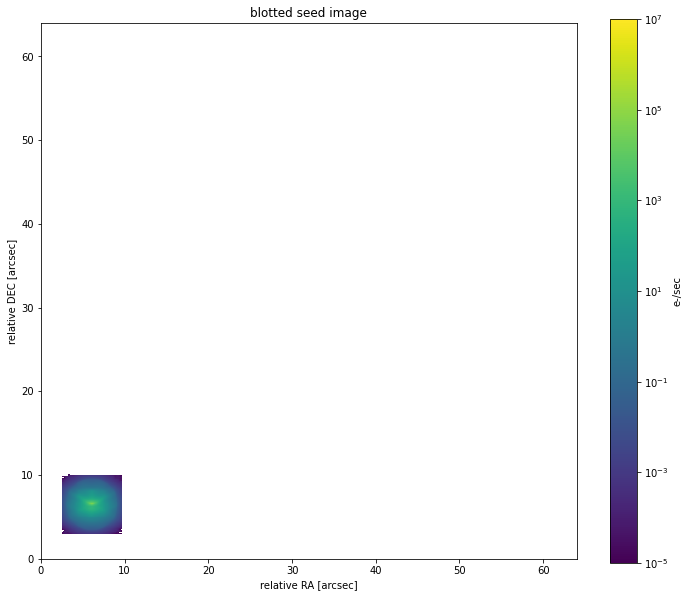

In [12]:
img_show(filename_blot, "blotted seed image", \
    norm=matplotlib.colors.LogNorm(1e-5, 1e7))

Blotted image, cropped to subarray area

Data type for plotting: '>f4'


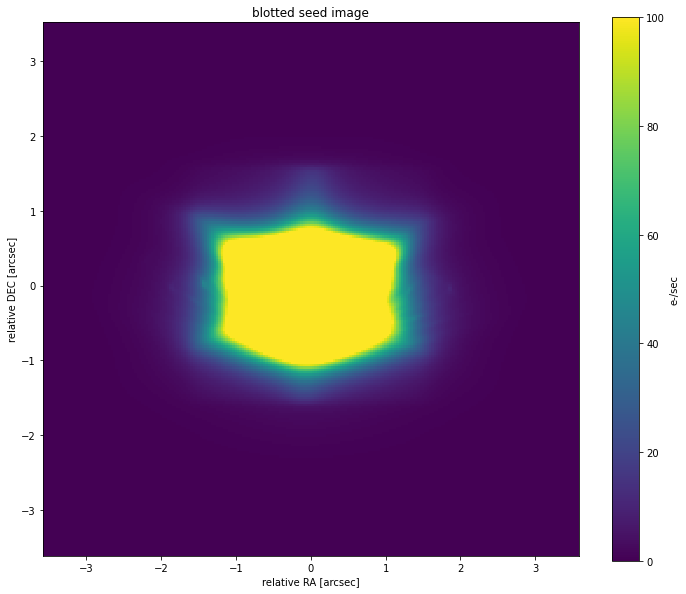

In [13]:
img_show(filename_blot, "blotted seed image", cut=filename_blot, \
    norm=matplotlib.colors.Normalize(0.0, 1.0e2))

Uncalibrated image: one channel

Data type for plotting: 'float64'


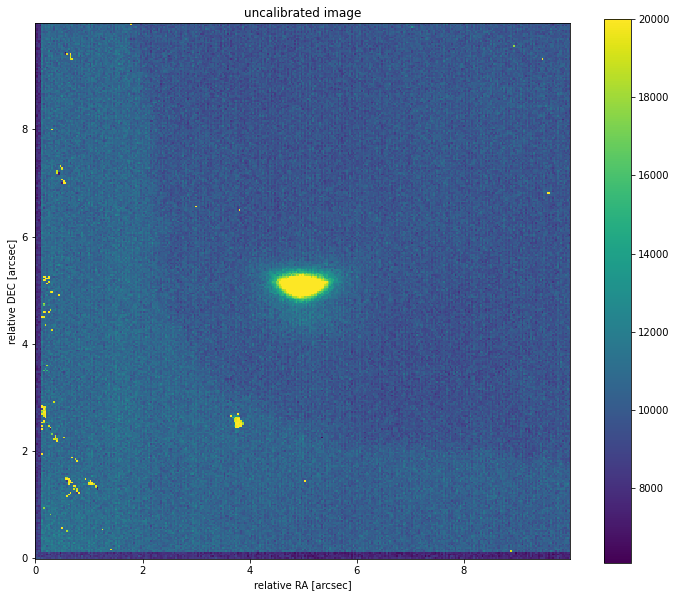

In [14]:
img_show(filename_uncal, "uncalibrated image", cut=None, take=0, \
    norm=matplotlib.colors.Normalize(vmax=2e4))

Uncalibrated image: two channels subtracted

Data type for plotting: 'float64'


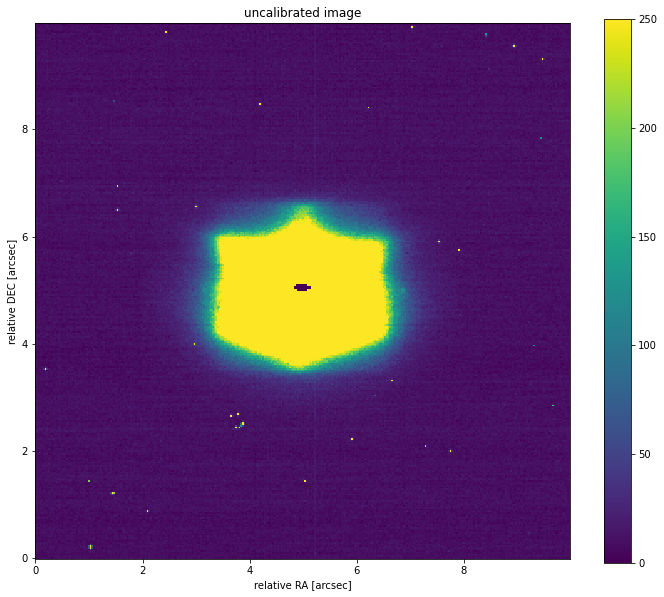

In [15]:
img_show(filename_uncal, "uncalibrated image", cut=None, take=[1,0], \
    norm=matplotlib.colors.Normalize(vmin=0, vmax=250))

The 'linearized' output seems to be meant just for quick visual checking.

Data type for plotting: 'float64'


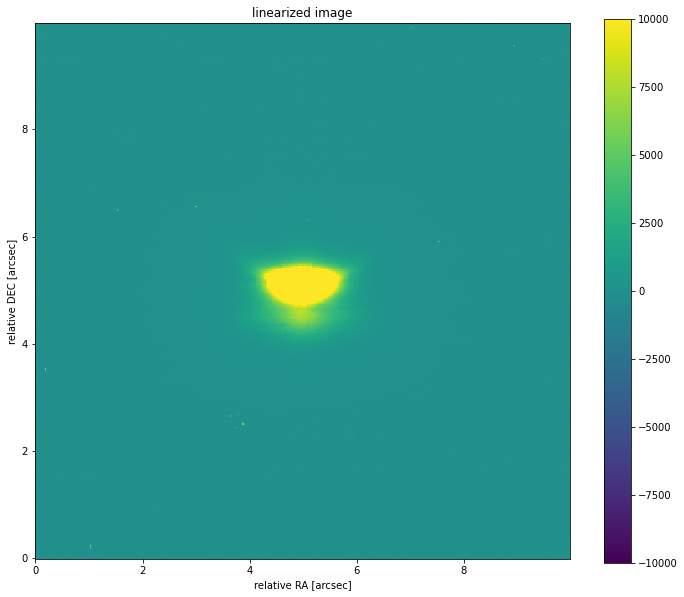

In [16]:
img_show(filename_lin, "linearized image", cut=None, take=[1,0], \
    norm=matplotlib.colors.Normalize(-1.0e4,1.0e4))

# Data calibration

The uncalibrated images can/should now be run through the pipeline provided by `jwst`.
Since `mirage` currently does not seem to work with the latest version of `jwst` (see https://github.com/spacetelescope/mirage/issues/704; however, I had no issues using said latest version), running the pipeline in a separate `conda` environment is an option.

For starters, let's just make sure we are processing a suitable file.

In [17]:
with astropy.io.fits.open(filename_uncal) as hdul :
    assert hdul["PRIMARY"].header["EXP_TYPE"]=="NRC_IMAGE", \
        "Wrong exposure type for the pipeline below."

#### Stage 1: Detector-level corrections and ramp fitting for individual exposures

The intermediate products do not need to be saved into files; but by doing so, we know exactly what is being used where (since some pipeline steps produce more than one data set).

In [18]:
stage1 = jwst.pipeline.Detector1Pipeline.call(filename_uncal, \
    save_results=True, output_dir=folder_output)
filename_stage1 = filename_uncal.replace("_uncal.fits", "_rate.fits")

2021-10-11 18:17:40,878 - root - INFO - PARS-DETECTOR1PIPELINE parameters found: /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_pars-detector1pipeline_0002.asdf


2021-10-11 18:17:40,920 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-11 18:17:40,920 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-11 18:17:40,924 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-11 18:17:40,924 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-11 18:17:40,929 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-11 18:17:40,929 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-11 18:17:40,932 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-11 18:17:40,932 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-11 18:17:40,936 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-11 18:17:40,936 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-11 18:17:40,939 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-11 18:17:40,939 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-11 18:17:40,943 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-11 18:17:40,943 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-11 18:17:40,946 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-11 18:17:40,946 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-11 18:17:40,956 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-11 18:17:40,956 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-11 18:17:40,959 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-11 18:17:40,959 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-11 18:17:40,963 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-11 18:17:40,963 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-11 18:17:40,966 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-11 18:17:40,966 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-11 18:17:40,970 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-11 18:17:40,970 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-11 18:17:40,974 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-11 18:17:40,974 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2021-10-11 18:17:41,398 - py.warnings - WARNING - /e/ocean1/users/rfranz/Lib/MiniConda3/envs/codec/lib/python3.7/site-packages/stpipe/config_parser.py:330: ResourceWarning: unclosed file <_io.FileIO name='/e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb1_uncal.fits' mode='rb' closefd=True>
  section=section)



2021-10-11 18:17:41,483 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-11 18:17:41,483 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-11 18:17:41,488 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-11 18:17:41,488 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-11 18:17:41,492 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-11 18:17:41,492 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-11 18:17:41,791 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb1_uncal.fits',).


2021-10-11 18:17:41,791 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb1_uncal.fits',).


2021-10-11 18:17:41,816 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'custom-output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': N

2021-10-11 18:17:41,816 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'custom-output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': N

2021-10-11 18:17:42,174 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw00042001001_01101_00001_nrcb1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-11 18:17:42,174 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw00042001001_01101_00001_nrcb1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-11 18:17:42,187 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_dark_0059.fits'.


2021-10-11 18:17:42,187 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_dark_0059.fits'.


2021-10-11 18:17:42,189 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_gain_0053.fits'.


2021-10-11 18:17:42,189 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_gain_0053.fits'.


2021-10-11 18:17:42,191 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_linearity_0057.fits'.


2021-10-11 18:17:42,191 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_linearity_0057.fits'.


2021-10-11 18:17:42,193 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_mask_0042.fits'.


2021-10-11 18:17:42,193 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_mask_0042.fits'.


2021-10-11 18:17:42,195 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_persat_0025.fits'.


2021-10-11 18:17:42,195 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_persat_0025.fits'.


2021-10-11 18:17:42,197 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_readnoise_0039.fits'.


2021-10-11 18:17:42,197 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_readnoise_0039.fits'.


2021-10-11 18:17:42,199 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2021-10-11 18:17:42,199 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2021-10-11 18:17:42,200 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-11 18:17:42,200 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-11 18:17:42,201 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2021-10-11 18:17:42,201 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2021-10-11 18:17:42,203 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_saturation_0058.fits'.


2021-10-11 18:17:42,203 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_saturation_0058.fits'.


2021-10-11 18:17:42,205 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_superbias_0020.fits'.


2021-10-11 18:17:42,205 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_superbias_0020.fits'.


2021-10-11 18:17:42,207 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_trapdensity_0001.fits'.


2021-10-11 18:17:42,207 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_trapdensity_0001.fits'.


2021-10-11 18:17:42,209 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_trappars_0001.fits'.


2021-10-11 18:17:42,209 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_trappars_0001.fits'.
2021-10-11 18:17:42,211 - root - INFO - Starting calwebb_detector1 ...


2021-10-11 18:17:42,959 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:17:42,959 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:17:42,963 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output'}


2021-10-11 18:17:42,963 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output'}


2021-10-11 18:17:43,110 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=8 is a power of 2; correction not needed


2021-10-11 18:17:43,110 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=8 is a power of 2; correction not needed


2021-10-11 18:17:43,112 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-11 18:17:43,112 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-11 18:17:43,116 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-11 18:17:43,116 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-11 18:17:43,443 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:17:43,443 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:17:43,447 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output'}


2021-10-11 18:17:43,447 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output'}


2021-10-11 18:17:43,505 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_mask_0042.fits


2021-10-11 18:17:43,505 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_mask_0042.fits
2021-10-11 18:17:44,690 - jwst.dq_init.dq_initialization - INFO - Extracting mask subarray to match science data


2021-10-11 18:17:44,714 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-11 18:17:44,714 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-11 18:17:45,073 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:17:45,073 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:17:45,078 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output'}


2021-10-11 18:17:45,078 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output'}


2021-10-11 18:17:45,139 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_saturation_0058.fits


2021-10-11 18:17:45,139 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_saturation_0058.fits
2021-10-11 18:17:45,496 - jwst.saturation.saturation - INFO - Extracting reference file subarray to match science data
2021-10-11 18:17:45,628 - jwst.saturation.saturation - INFO - Detected 3897 saturated pixels
2021-10-11 18:17:45,638 - jwst.saturation.saturation - INFO - Detected 0 A/D floor pixels


2021-10-11 18:17:45,648 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-11 18:17:45,648 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-11 18:17:45,979 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:17:45,979 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:17:45,983 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output'}


2021-10-11 18:17:45,983 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output'}


2021-10-11 18:17:45,986 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-11 18:17:45,986 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-11 18:17:45,990 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-11 18:17:45,990 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-11 18:17:46,308 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:17:46,308 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:17:46,313 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output'}


2021-10-11 18:17:46,313 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output'}


2021-10-11 18:17:46,372 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_superbias_0020.fits


2021-10-11 18:17:46,372 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_superbias_0020.fits


2021-10-11 18:17:46,912 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2021-10-11 18:17:46,912 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2021-10-11 18:17:47,230 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:17:47,230 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:17:47,237 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-11 18:17:47,237 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-11 18:17:47,269 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2021-10-11 18:17:47,269 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2021-10-11 18:17:47,275 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2021-10-11 18:17:47,275 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2021-10-11 18:17:47,281 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2021-10-11 18:17:47,281 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2021-10-11 18:17:47,287 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


2021-10-11 18:17:47,287 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


2021-10-11 18:17:47,290 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2021-10-11 18:17:47,290 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2021-10-11 18:17:48,771 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-11 18:17:48,771 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-11 18:17:49,079 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:17:49,079 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:17:49,085 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output'}


2021-10-11 18:17:49,085 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output'}


2021-10-11 18:17:49,146 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_linearity_0057.fits


2021-10-11 18:17:49,146 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_linearity_0057.fits
2021-10-11 18:17:49,638 - jwst.linearity.linearity - INFO - Extracting linearity subarray to match science data


2021-10-11 18:17:49,921 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-11 18:17:49,921 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-11 18:17:50,277 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:17:50,277 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:17:50,284 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output', 'input_trapsfilled': '', 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


2021-10-11 18:17:50,284 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output', 'input_trapsfilled': '', 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


2021-10-11 18:18:00,181 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in custom-output/jw00042001001_01101_00001_nrcb1_trapsfilled.fits


2021-10-11 18:18:00,181 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in custom-output/jw00042001001_01101_00001_nrcb1_trapsfilled.fits


2021-10-11 18:18:00,192 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence done


2021-10-11 18:18:00,192 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence done


2021-10-11 18:18:00,580 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:18:00,580 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:18:00,584 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'custom-output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output', 'dark_output': None}


2021-10-11 18:18:00,584 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'custom-output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output', 'dark_output': None}


2021-10-11 18:18:00,642 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_dark_0059.fits


2021-10-11 18:18:00,642 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_dark_0059.fits
2021-10-11 18:18:00,735 - jwst.dark_current.dark_sub - INFO - Science data nints=10, ngroups=10, nframes=8, groupgap=12
2021-10-11 18:18:00,736 - jwst.dark_current.dark_sub - INFO - Dark data nints=1, ngroups=20, nframes=1, groupgap=0
2021-10-11 18:18:00,737 - jwst.dark_current.dark_sub - WARNING - Not enough data in dark reference file to match to science data.
2021-10-11 18:18:00,738 - jwst.dark_current.dark_sub - WARNING - Input will be returned without subtracting dark current.


2021-10-11 18:18:00,908 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-11 18:18:00,908 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-11 18:18:01,220 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:18:01,220 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:18:01,226 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-11 18:18:01,226 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-11 18:18:01,255 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-11 18:18:01,255 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-11 18:18:01,289 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_gain_0053.fits


2021-10-11 18:18:01,289 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_gain_0053.fits


2021-10-11 18:18:01,401 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_readnoise_0039.fits


2021-10-11 18:18:01,401 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_readnoise_0039.fits
2021-10-11 18:18:01,455 - jwst.jump.jump - INFO - Using 1 core for jump detection 
2021-10-11 18:18:01,618 - jwst.jump.jump - INFO - Extracting gain subarray to match science data
2021-10-11 18:18:01,620 - jwst.jump.jump - INFO - Extracting readnoise subarray to match science data
2021-10-11 18:18:01,673 - jwst.jump.jump - INFO - Executing two-point difference method
2021-10-11 18:18:01,875 - jwst.jump.twopoint_difference - INFO - Working on integration 1:
2021-10-11 18:18:01,965 - jwst.jump.twopoint_difference - INFO - From highest outlier Two-point found 27819 pixels with at least one CR and at least four groups
2021-10-11 18:18:01,966 - jwst.jump.twopoint_difference - INFO - From highest outlier Two-point found 2 pixels with at least one CR and three groups
2021-10-11 18:18:01,967 - jwst.j

2021-10-11 18:18:19,894 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 18.639332


2021-10-11 18:18:19,894 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 18.639332


2021-10-11 18:18:19,904 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-11 18:18:19,904 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-11 18:18:20,302 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:18:20,302 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(10, 10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:18:20,307 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'custom-output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-11 18:18:20,307 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'custom-output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}
2021-10-11 18:18:20,397 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_readnoise_0039.fits
2021-10-11 18:18:20,449 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_gain_0053.fits
2021-10-11 18:18:20,531 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = ols
2021-10-11 18:18:20,532 - jwst.r

2021-10-11 18:18:45,729 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-11 18:18:45,729 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-11 18:18:46,125 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:18:46,125 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:18:46,132 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output'}


2021-10-11 18:18:46,132 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output'}


2021-10-11 18:18:46,253 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-11 18:18:46,253 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-11 18:18:46,255 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-11 18:18:46,255 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-11 18:18:46,263 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-11 18:18:46,263 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-11 18:18:46,589 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:18:46,589 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(10, 320, 320) from jw00042001001_01101_00001_nrcb1_uncal.fits>,).


2021-10-11 18:18:46,593 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output'}


2021-10-11 18:18:46,593 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output'}


2021-10-11 18:18:46,720 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-11 18:18:46,720 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-11 18:18:46,722 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-11 18:18:46,722 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-11 18:18:46,730 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-11 18:18:46,730 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-11 18:18:46,919 - stpipe.Detector1Pipeline - INFO - Saved model in custom-output/jw00042001001_01101_00001_nrcb1_rateints.fits


2021-10-11 18:18:46,919 - stpipe.Detector1Pipeline - INFO - Saved model in custom-output/jw00042001001_01101_00001_nrcb1_rateints.fits
2021-10-11 18:18:46,923 - root - INFO - ... ending calwebb_detector1


2021-10-11 18:18:47,056 - stpipe.Detector1Pipeline - INFO - Saved model in custom-output/jw00042001001_01101_00001_nrcb1_rate.fits


2021-10-11 18:18:47,056 - stpipe.Detector1Pipeline - INFO - Saved model in custom-output/jw00042001001_01101_00001_nrcb1_rate.fits


2021-10-11 18:18:47,058 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-11 18:18:47,058 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


In [19]:
print()  # merely to clear the output buffer; also: will not print if something has gone wrong above

Quick plot

Data type for plotting: '>f4'


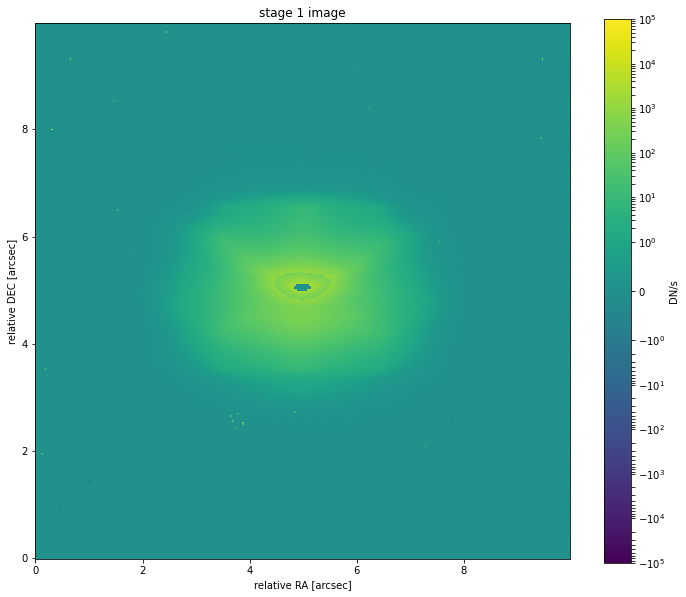

In [20]:
img_show(filename_stage1, "stage 1 image", \
    norm=matplotlib.colors.SymLogNorm(linthresh=1e0, vmin=-1e5, vmax=1e5))

Optional: check that the image produced from the file (above) matches the data array in memory

#### Stage 2: Instrument-mode calibrations for individual exposures

In [21]:
stage2 = jwst.pipeline.Image2Pipeline.call(filename_stage1, \
    save_results=True, output_dir=folder_output)
filename_stage2 = filename_stage1.replace("_rate.fits", "_cal.fits")

2021-10-11 18:18:48,656 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2021-10-11 18:18:48,656 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2021-10-11 18:18:48,660 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-11 18:18:48,660 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-11 18:18:48,665 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-11 18:18:48,665 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-11 18:18:48,670 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-11 18:18:48,670 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-11 18:18:48,674 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-11 18:18:48,674 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-11 18:18:48,678 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2021-10-11 18:18:48,678 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2021-10-11 18:18:49,028 - py.warnings - WARNING - /e/ocean1/users/rfranz/Lib/MiniConda3/envs/codec/lib/python3.7/site-packages/stpipe/step.py:359: ResourceWarning: unclosed file <_io.FileIO name='/e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-11 18:18:49,078 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb1_rate.fits',).


2021-10-11 18:18:49,078 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb1_rate.fits',).


2021-10-11 18:18:49,091 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'custom-output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx':

2021-10-11 18:18:49,091 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'custom-output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx':

2021-10-11 18:18:49,181 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw00042001001_01101_00001_nrcb1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-10-11 18:18:49,181 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw00042001001_01101_00001_nrcb1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-10-11 18:18:49,192 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_area_0021.fits'.


2021-10-11 18:18:49,192 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_area_0021.fits'.


2021-10-11 18:18:49,195 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-11 18:18:49,195 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-11 18:18:49,196 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-11 18:18:49,196 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-11 18:18:49,198 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-11 18:18:49,198 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-11 18:18:49,199 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-11 18:18:49,199 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-11 18:18:49,201 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_distortion_0100.asdf'.


2021-10-11 18:18:49,201 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_distortion_0100.asdf'.


2021-10-11 18:18:49,203 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_drizpars_0001.fits'.


2021-10-11 18:18:49,203 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_drizpars_0001.fits'.


2021-10-11 18:18:49,204 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-11 18:18:49,204 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-11 18:18:49,207 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_filteroffset_0003.asdf'.


2021-10-11 18:18:49,207 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_filteroffset_0003.asdf'.


2021-10-11 18:18:49,209 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_flat_0386.fits'.


2021-10-11 18:18:49,209 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_flat_0386.fits'.


2021-10-11 18:18:49,211 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-11 18:18:49,211 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-11 18:18:49,212 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-11 18:18:49,212 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-11 18:18:49,214 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-11 18:18:49,214 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-11 18:18:49,216 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-11 18:18:49,216 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-11 18:18:49,218 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-11 18:18:49,218 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-11 18:18:49,220 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-11 18:18:49,220 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-11 18:18:49,221 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-11 18:18:49,221 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-11 18:18:49,223 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_photom_0090.fits'.


2021-10-11 18:18:49,223 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_photom_0090.fits'.


2021-10-11 18:18:49,224 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-10-11 18:18:49,224 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-10-11 18:18:49,227 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-11 18:18:49,227 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-11 18:18:49,228 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-10-11 18:18:49,228 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-10-11 18:18:49,230 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-10-11 18:18:49,230 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-10-11 18:18:49,231 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-11 18:18:49,231 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-11 18:18:49,235 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-10-11 18:18:49,235 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-10-11 18:18:49,237 - stpipe.Image2Pipeline - INFO - Processing product /e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb1


2021-10-11 18:18:49,237 - stpipe.Image2Pipeline - INFO - Processing product /e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb1


2021-10-11 18:18:49,238 - stpipe.Image2Pipeline - INFO - Working on input /e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb1_rate.fits ...


2021-10-11 18:18:49,238 - stpipe.Image2Pipeline - INFO - Working on input /e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb1_rate.fits ...


2021-10-11 18:18:49,653 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(320, 320) from jw00042001001_01101_00001_nrcb1_rate.fits>,).


2021-10-11 18:18:49,653 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(320, 320) from jw00042001001_01101_00001_nrcb1_rate.fits>,).


2021-10-11 18:18:49,657 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-11 18:18:49,657 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2021-10-11 18:18:50,363 - py.warnings - WARNING - /e/ocean1/users/rfranz/Lib/MiniConda3/envs/codec/lib/python3.7/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the prec

2021-10-11 18:18:50,473 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-11 18:18:50,473 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-11 18:18:50,809 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(320, 320) from jw00042001001_01101_00001_nrcb1_rate.fits>,).


2021-10-11 18:18:50,809 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(320, 320) from jw00042001001_01101_00001_nrcb1_rate.fits>,).


2021-10-11 18:18:50,814 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-11 18:18:50,814 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2021-10-11 18:18:51,328 - jwst.flatfield.flat_field - INFO - Extracting matching subarray from flat


2021-10-11 18:18:51,372 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-10-11 18:18:51,372 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-10-11 18:18:51,701 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(320, 320) from jw00042001001_01101_00001_nrcb1_rate.fits>,).


2021-10-11 18:18:51,701 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(320, 320) from jw00042001001_01101_00001_nrcb1_rate.fits>,).


2021-10-11 18:18:51,706 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output', 'inverse': False, 'source_type': None}


2021-10-11 18:18:51,706 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output', 'inverse': False, 'source_type': None}


2021-10-11 18:18:51,781 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_photom_0090.fits


2021-10-11 18:18:51,781 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_photom_0090.fits


2021-10-11 18:18:51,784 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_area_0021.fits


2021-10-11 18:18:51,784 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_area_0021.fits
2021-10-11 18:18:51,951 - jwst.photom.photom - INFO - Using instrument: NIRCAM
2021-10-11 18:18:51,952 - jwst.photom.photom - INFO -  detector: NRCB1
2021-10-11 18:18:51,953 - jwst.photom.photom - INFO -  exp_type: NRC_IMAGE
2021-10-11 18:18:51,954 - jwst.photom.photom - INFO -  filter: F070W
2021-10-11 18:18:51,955 - jwst.photom.photom - INFO -  pupil: CLEAR
2021-10-11 18:18:52,092 - jwst.photom.photom - INFO - Pixel area map copied to output.
2021-10-11 18:18:52,098 - jwst.photom.photom - INFO - PHOTMJSR value: 5.10502


2021-10-11 18:18:52,117 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-10-11 18:18:52,117 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-10-11 18:18:52,488 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(320, 320) from jw00042001001_01101_00001_nrcb1_rate.fits>,).


2021-10-11 18:18:52,488 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(320, 320) from jw00042001001_01101_00001_nrcb1_rate.fits>,).


2021-10-11 18:18:52,493 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-10-11 18:18:52,493 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '/e/ocean1/users/rfranz/Code/mirage-test/custom-output', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-10-11 18:18:52,567 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_drizpars_0001.fits


2021-10-11 18:18:52,567 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_drizpars_0001.fits
2021-10-11 18:18:54,749 - py.warnings - WARNING - /e/ocean1/users/rfranz/Lib/MiniConda3/envs/codec/lib/python3.7/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-11 18:18:54,981 - stpipe.Image2Pipeline.resample - INFO - Saved model in custom-output/jw00042001001_01101_00001_nrcb1_i2d.fits


2021-10-11 18:18:54,981 - stpipe.Image2Pipeline.resample - INFO - Saved model in custom-output/jw00042001001_01101_00001_nrcb1_i2d.fits


2021-10-11 18:18:54,989 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-10-11 18:18:54,989 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-10-11 18:18:54,995 - stpipe.Image2Pipeline - INFO - Finished processing product /e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb1


2021-10-11 18:18:54,995 - stpipe.Image2Pipeline - INFO - Finished processing product /e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb1


2021-10-11 18:18:55,004 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-10-11 18:18:55,004 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-10-11 18:18:55,308 - stpipe.Image2Pipeline - INFO - Saved model in custom-output/jw00042001001_01101_00001_nrcb1_cal.fits


2021-10-11 18:18:55,308 - stpipe.Image2Pipeline - INFO - Saved model in custom-output/jw00042001001_01101_00001_nrcb1_cal.fits


2021-10-11 18:18:55,311 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-10-11 18:18:55,311 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


In [22]:
print()  # merely to clear the output buffer; also: will not print if something has gone wrong above

Quick plot

Data type for plotting: '>f4'


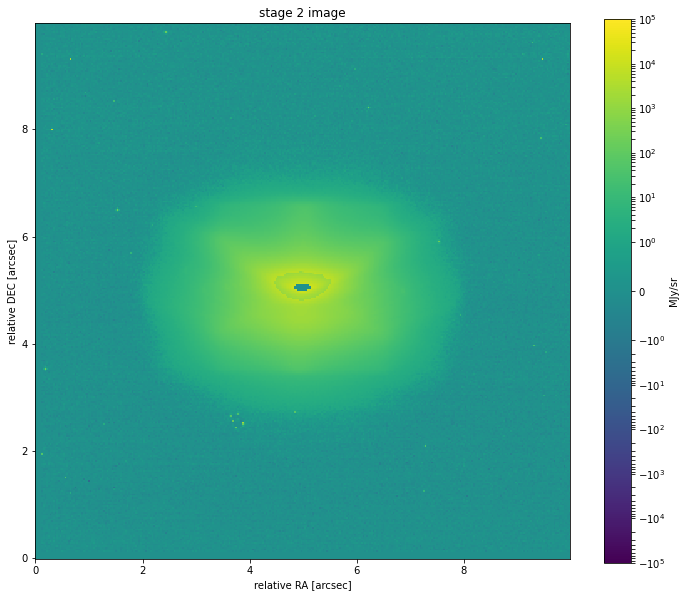

In [23]:
img_show(filename_stage2, "stage 2 image", \
    norm=matplotlib.colors.SymLogNorm(linthresh=1e0, vmin=-1e5, vmax=1e5))

Optional: check that the image produced from the file (above) matches the data array in memory

#### Stage 3: Combining data from multiple exposures within an observation

We only have one exposure, but still want distortion correction etc.

In [24]:
stage3 = jwst.pipeline.Image3Pipeline.call([filename_stage2], \
    save_results=True, output_dir=folder_output)
filename_stage3 = f"{folder_output:s}/step_i2d.fits"

2021-10-11 18:18:57,012 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2021-10-11 18:18:57,012 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2021-10-11 18:18:57,016 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2021-10-11 18:18:57,016 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2021-10-11 18:18:57,022 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2021-10-11 18:18:57,022 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2021-10-11 18:18:57,027 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2021-10-11 18:18:57,027 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2021-10-11 18:18:57,032 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2021-10-11 18:18:57,032 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2021-10-11 18:18:57,036 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2021-10-11 18:18:57,036 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2021-10-11 18:18:57,041 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2021-10-11 18:18:57,041 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2021-10-11 18:18:57,444 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args (['/e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb1_cal.fits'],).


2021-10-11 18:18:57,444 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args (['/e/ocean1/users/rfranz/Code/mirage-test/custom-output/jw00042001001_01101_00001_nrcb1_cal.fits'],).


2021-10-11 18:18:57,465 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'custom-output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 10.0, '

2021-10-11 18:18:57,465 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'custom-output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 10.0, '

2021-10-11 18:18:57,690 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'jw00042001001_01101_00001_nrcb1_cal.fits' reftypes = ['abvegaoffset', 'apcorr', 'drizpars']


2021-10-11 18:18:57,690 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'jw00042001001_01101_00001_nrcb1_cal.fits' reftypes = ['abvegaoffset', 'apcorr', 'drizpars']


2021-10-11 18:18:57,709 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_abvegaoffset_0001.asdf'.


2021-10-11 18:18:57,709 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_abvegaoffset_0001.asdf'.


2021-10-11 18:18:57,711 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_apcorr_0004.fits'.


2021-10-11 18:18:57,711 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_apcorr_0004.fits'.


2021-10-11 18:18:57,714 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_drizpars_0001.fits'.


2021-10-11 18:18:57,714 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_drizpars_0001.fits'.


2021-10-11 18:18:57,716 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2021-10-11 18:18:57,716 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2021-10-11 18:18:58,296 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2021-10-11 18:18:58,296 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2021-10-11 18:18:58,302 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'skymethod': 'global+match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '0', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}


2021-10-11 18:18:58,302 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'skymethod': 'global+match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '0', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}
2021-10-11 18:18:58,328 - jwst.skymatch.skymatch - INFO -  
2021-10-11 18:18:58,330 - jwst.skymatch.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2021-10-11 18:18:58.328859
2021-10-11 18:18:58,331 - jwst.skymatch.skymatch - INFO -  
2021-10-11 18:18:58,332 - jwst.skymatch.skymatch - INFO - Sky computation method: 'global+match'
2021-10-11 18:18:58,333 - jwst.skymatch.skymatch - INFO - Sky matching direction: DOWN
2021-1

2021-10-11 18:18:58,360 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2021-10-11 18:18:58,360 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2021-10-11 18:18:58,685 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2021-10-11 18:18:58,685 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2021-10-11 18:18:58,689 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-10-11 18:18:58,689 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-10-11 18:18:58,726 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_drizpars_0001.fits


2021-10-11 18:18:58,726 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_drizpars_0001.fits
2021-10-11 18:19:02,113 - py.warnings - WARNING - /e/ocean1/users/rfranz/Lib/MiniConda3/envs/codec/lib/python3.7/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-11 18:19:03,260 - stpipe.Image3Pipeline.resample - INFO - Saved model in custom-output/step_i2d.fits


2021-10-11 18:19:03,260 - stpipe.Image3Pipeline.resample - INFO - Saved model in custom-output/step_i2d.fits


2021-10-11 18:19:03,263 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2021-10-11 18:19:03,263 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2021-10-11 18:19:03,660 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(321, 320) from step_i2d.fits>,).


2021-10-11 18:19:03,660 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(321, 320) from step_i2d.fits>,).


2021-10-11 18:19:03,665 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '', 'bkg_boxsize': 100, 'kernel_fwhm': 2.0, 'snr_threshold': 3.0, 'npixels': 5, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2021-10-11 18:19:03,665 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '', 'bkg_boxsize': 100, 'kernel_fwhm': 2.0, 'snr_threshold': 3.0, 'npixels': 5, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2021-10-11 18:19:03,714 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_apcorr_0004.fits


2021-10-11 18:19:03,714 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_apcorr_0004.fits


2021-10-11 18:19:03,742 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_abvegaoffset_0001.asdf


2021-10-11 18:19:03,742 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file /e/ocean1/users/rfranz/Lib/Mirage/CRDS_CACHE/references/jwst/nircam/jwst_nircam_abvegaoffset_0001.asdf
2021-10-11 18:19:03,745 - jwst.source_catalog.source_catalog - INFO - Instrument: NIRCAM
2021-10-11 18:19:03,746 - jwst.source_catalog.source_catalog - INFO - Detector: NRCB1
2021-10-11 18:19:03,747 - jwst.source_catalog.source_catalog - INFO - Filter: F070W
2021-10-11 18:19:03,748 - jwst.source_catalog.source_catalog - INFO - Pupil: CLEAR
2021-10-11 18:19:03,749 - jwst.source_catalog.source_catalog - INFO - Subarray: SUB320
2021-10-11 18:19:03,869 - jwst.source_catalog.source_catalog - INFO - AB to Vega magnitude offset 0.24976


2021-10-11 18:19:04,013 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 6 sources


2021-10-11 18:19:04,013 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 6 sources


2021-10-11 18:19:04,243 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: custom-output/step_cat.ecsv


2021-10-11 18:19:04,243 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: custom-output/step_cat.ecsv


2021-10-11 18:19:04,516 - stpipe.Image3Pipeline.source_catalog - INFO - Saved model in custom-output/step_segm.fits


2021-10-11 18:19:04,516 - stpipe.Image3Pipeline.source_catalog - INFO - Saved model in custom-output/step_segm.fits


2021-10-11 18:19:04,519 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote segmentation map: step_segm.fits


2021-10-11 18:19:04,519 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote segmentation map: step_segm.fits


2021-10-11 18:19:04,522 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2021-10-11 18:19:04,522 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2021-10-11 18:19:04,525 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


2021-10-11 18:19:04,525 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


In [25]:
print()  # merely to clear the output buffer; also: will not print if something has gone wrong above

#### Resulting plots

(1) input file for comparison

Data type for plotting: '>f8'


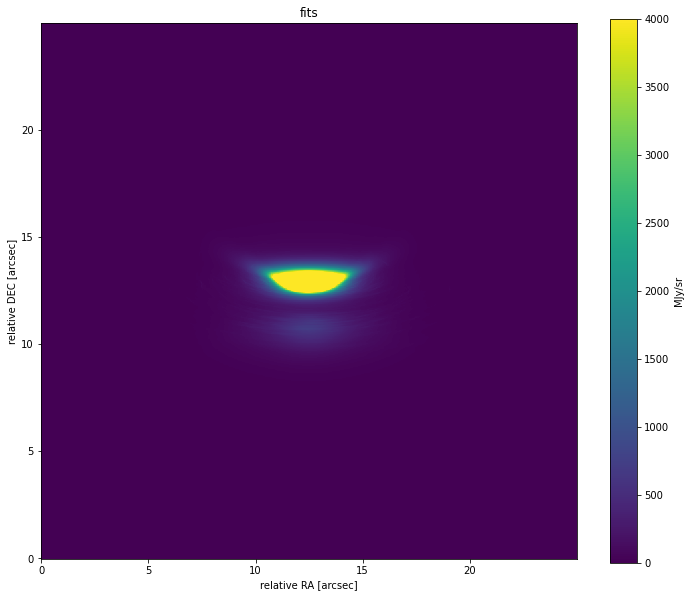

In [26]:
img_show(filename_fits, "fits", \
    norm=matplotlib.colors.Normalize(vmin=0, vmax=4e3))

(2) final `Mirage` output

Data type for plotting: '>f4'


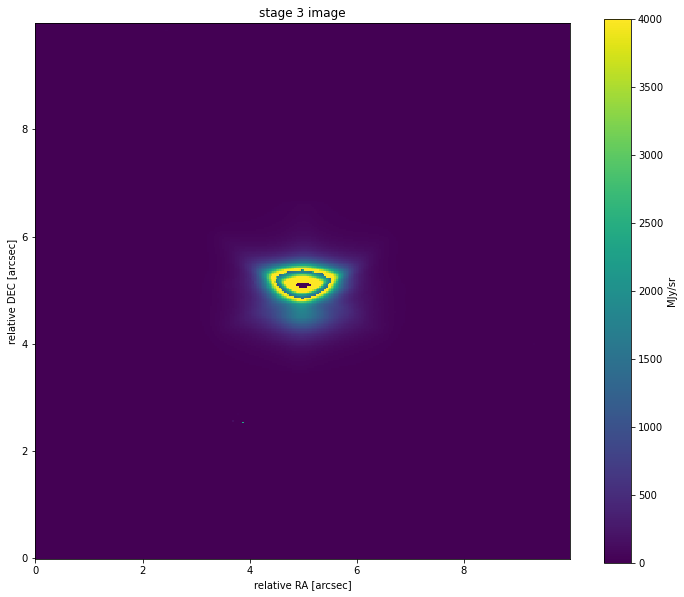

In [27]:
img_show(filename_stage3, "stage 3 image", \
    norm=matplotlib.colors.Normalize(vmin=0, vmax=4e3))

Data type for plotting: '>f4'


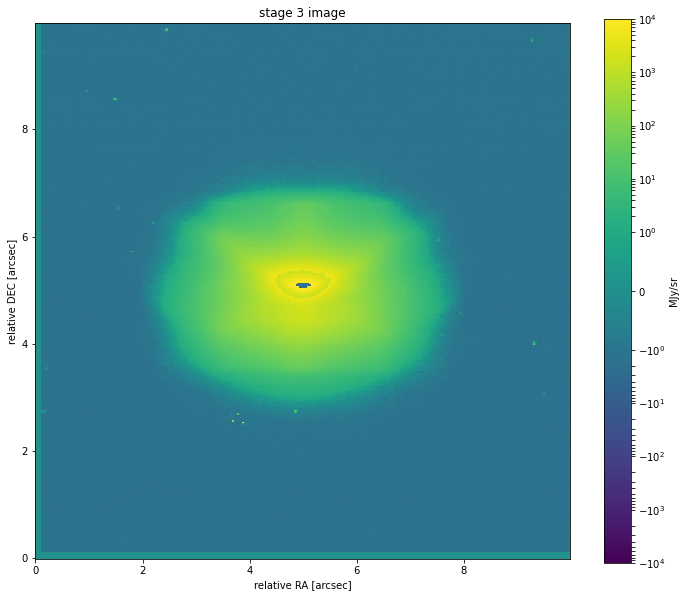

In [28]:
img_show(filename_stage3, "stage 3 image", \
    norm=matplotlib.colors.SymLogNorm(linthresh=1e0, vmin=-1e4, vmax=1e4))